

---


# **Combination of Dataframes and ML prediction**
#### ***Look before you Leap : Leveraging Predictive Models to Improve Automotive Safety and Travel Time***



---



**Final Project**
CSCI 35300/79502   |   Fall 2020 

##### Hannah Do







In [2]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import datetime, string, re
import sys, os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from collections import Counter

print('All Libraries Sucessfully Imported')

All Libraries Sucessfully Imported


In [3]:
! pip install imbalanced-learn


In [4]:
import imblearn
print(imblearn.__version__)

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where

0.7.0


---
### Merging dataframes - traffic + tweet
- Importing previously saved csv files

In [8]:
traffic = pd.read_csv("data_traffic/accident_Jun_2020.csv", index_col= None, header = None)
tweet = pd.read_csv("data_twitter/locat_11b.csv", index_col= None, header = None)

traffic = traffic.drop([0], axis=1)
tweet = tweet.drop([0], axis=1)

# drop NaN column with index values

traffic.columns = traffic.iloc[0]
traffic = traffic[1:] 
tweet.columns = tweet.iloc[0]
tweet = tweet[1:] 
# make first row as column names
    


In [9]:

tweet['longitude'] = tweet['longitude'].apply(lambda x: float(x))
tweet['latitude'] = tweet['latitude'].apply(lambda x: float(x))
traffic['LONGITUDE'] = traffic['LONGITUDE'].apply(lambda x: float(x))
traffic['LATITUDE'] = traffic['LATITUDE'].apply(lambda x: float(x))

traffic

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
1,2020-06-30,11:00,NaN,NaN,40.607243,-73.987260,"(40.607243, -73.98726)",AVENUE P,NaN,0,...,0,0,0,0,0,Unspecified,NaN,4324995,Station Wagon/Sport Utility Vehicle,NaN
2,2020-06-30,15:40,NaN,NaN,40.782787,-73.957410,"(40.782787, -73.95741)",EAST 89 STREET,NaN,0,...,0,0,0,0,0,Unspecified,NaN,4324800,Station Wagon/Sport Utility Vehicle,NaN
3,2020-06-28,14:30,NaN,NaN,40.707860,-73.848460,"(40.70786, -73.84846)",JACKIE ROBINSON PKWY,NaN,1,...,0,0,0,1,0,Following Too Closely,Unspecified,4323925,Sedan,Sedan
4,2020-06-27,19:20,BROOKLYN,11210,40.628730,-73.943340,"(40.62873, -73.94334)",EAST 34 STREET,FLATBUSH AVENUE,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,4326375,Sedan,Sedan
5,2020-06-25,14:00,NaN,NaN,40.757725,-73.779274,"(40.757725, -73.779274)",204 STREET,NaN,0,...,0,0,0,0,0,Backing Unsafely,Unspecified,4323080,Sedan,Sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,2020-06-18,13:52,BRONX,10468.0,40.867680,-73.894660,"(40.86768, -73.89466)",NaN,NaN,1,...,0,0,0,0,0,Backing Unsafely,NaN,4321533,Sedan,NaN
6841,2020-06-11,17:20,MANHATTAN,10034.0,40.862410,-73.922500,"(40.86241, -73.9225)",NAGLE AVENUE,ACADEMY STREET,0,...,0,0,0,0,0,Driver Inattention/Distraction,NaN,4319426,Station Wagon/Sport Utility Vehicle,NaN
6842,2020-06-06,0:05,NaN,NaN,40.833010,-73.950270,"(40.83301, -73.95027)",HENRY HUDSON PARKWAY,NaN,0,...,0,0,0,0,0,Pavement Slippery,NaN,4318296,Sedan,NaN
6843,2020-06-22,4:10,NaN,NaN,40.903480,-73.850350,"(40.90348, -73.85035)",WHITE PLAINS ROAD,NaN,1,...,0,0,0,1,0,Unspecified,NaN,4322453,Sedan,NaN


In [10]:
# temp2 = temp2.reset_index(drop=True)

freq2 = pd.DataFrame()
freq2 = tweet.groupby(["longitude", "latitude"]).size().reset_index(name="Frequency")

freq2 = freq2.sort_values('Frequency', ascending=False)

freq2.drop(freq2.head(15).index,inplace=True)
# most frequent value is the default value that returns location of 'new york'

freq2[['polar score', 'neutral score']] = tweet[['polar score', 'neutral score']]

freq2 = freq2.reset_index(drop=True)


In [12]:
traffic['distance'] = 10000
traffic['severity'] = 0
traffic['polar sentiment'] = 0
traffic['neutral sentiment'] = 0

for i in range(len(traffic['LONGITUDE'])-1):
    for j in range(len(freq2['longitude'])-1):
        x = (np.sqrt(((traffic['LONGITUDE'][i+1]-freq2['longitude'][j+1])*100000)**2 + ((traffic['LATITUDE'][i+1]-freq2['latitude'][j+1])*100000)**2))
        if (x < 2000):
            traffic['severity'][i+1] += 1
            
            if (traffic['polar sentiment'][i+1]) == 0:
                traffic['polar sentiment'][i+1] = freq2['polar score'][j+1]
                traffic['neutral sentiment'][i+1] = freq2['neutral score'][j+1]
            else:
                traffic['polar sentiment'][i+1] = (float(traffic['polar sentiment'][i+1])+float(freq2['polar score'][j+1]))/2
                traffic['neutral sentiment'][i+1] = (float(traffic['neutral sentiment'][i+1])+float(freq2['neutral score'][j+1]))/2
            
            if (traffic['distance'][i+1] > x):
                traffic['distance'][i+1] = x
            else:
                pass
        else:
            pass


<ipython-input-12-8985a95b4136>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['severity'][i+1] += 1
<ipython-input-12-8985a95b4136>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['polar sentiment'][i+1] = freq2['polar score'][j+1]
<ipython-input-12-8985a95b4136>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['neutral sentiment'][i+1] = freq2['neutral score'][j+1]
<ipython-input-12-8985a95b4136>:20: Set

In [14]:
traffic.to_csv("appended_6a.csv", mode = 'a')


# appended_6a.csv
# appended_6b.csv
# appended_7a.csv
# appended_7b.csv
# ...
# appended_11a.csv
# appended_11b.csv

---

### Random sampling (SMOTE) due to class imbalance
- we currently only have accident(1) instances, which is why we will be create non-accident instances (0) through random sampling

In [15]:
temp = pd.read_csv("appended_6a.csv", sep=',')

# appended_6a.csv
# appended_6b.csv
# appended_7a.csv
# appended_7b.csv
# ...
# appended_11a.csv
# appended_11b.csv

temp = temp.drop(columns = ['Unnamed: 0'], axis=1)
# drop NaN column with index values

temp

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,distance,severity,polar sentiment,neutral sentiment
0,2020-06-30,11:00,NaN,NaN,40.607243,-73.987260,"(40.607243, -73.98726)",AVENUE P,NaN,0,...,0,Unspecified,NaN,4324995,Station Wagon/Sport Utility Vehicle,NaN,685,9,0.025675,0.962750
1,2020-06-30,15:40,NaN,NaN,40.782787,-73.957410,"(40.782787, -73.95741)",EAST 89 STREET,NaN,0,...,0,Unspecified,NaN,4324800,Station Wagon/Sport Utility Vehicle,NaN,440,7,0.000000,1.000000
2,2020-06-28,14:30,NaN,NaN,40.707860,-73.848460,"(40.70786, -73.84846)",JACKIE ROBINSON PKWY,NaN,1,...,0,Following Too Closely,Unspecified,4323925,Sedan,Sedan,800,4,0.159100,0.906500
3,2020-06-27,19:20,BROOKLYN,11210.0,40.628730,-73.943340,"(40.62873, -73.94334)",EAST 34 STREET,FLATBUSH AVENUE,0,...,0,Driver Inattention/Distraction,Unspecified,4326375,Sedan,Sedan,1644,2,0.051350,0.943500
4,2020-06-25,14:00,NaN,NaN,40.757725,-73.779274,"(40.757725, -73.779274)",204 STREET,NaN,0,...,0,Backing Unsafely,Unspecified,4323080,Sedan,Sedan,1156,1,0.476700,0.631000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,2020-06-18,13:52,BRONX,10468.0,40.867680,-73.894660,"(40.86768, -73.89466)",NaN,NaN,1,...,0,Backing Unsafely,NaN,4321533,Sedan,NaN,805,7,0.096281,0.891437
6840,2020-06-11,17:20,MANHATTAN,10034.0,40.862410,-73.922500,"(40.86241, -73.9225)",NAGLE AVENUE,ACADEMY STREET,0,...,0,Driver Inattention/Distraction,NaN,4319426,Station Wagon/Sport Utility Vehicle,NaN,339,15,0.097090,0.894098
6841,2020-06-06,0:05,NaN,NaN,40.833010,-73.950270,"(40.83301, -73.95027)",HENRY HUDSON PARKWAY,NaN,0,...,0,Pavement Slippery,NaN,4318296,Sedan,NaN,794,8,0.073816,0.910969
6842,2020-06-22,4:10,NaN,NaN,40.903480,-73.850350,"(40.90348, -73.85035)",WHITE PLAINS ROAD,NaN,1,...,0,Unspecified,NaN,4322453,Sedan,NaN,1449,2,0.051350,0.925500


In [16]:
temp['target']=1
temp

# adding target value to the existing accident dataset

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,distance,severity,polar sentiment,neutral sentiment,target
0,2020-06-30,11:00,NaN,NaN,40.607243,-73.987260,"(40.607243, -73.98726)",AVENUE P,NaN,0,...,Unspecified,NaN,4324995,Station Wagon/Sport Utility Vehicle,NaN,685,9,0.025675,0.962750,1
1,2020-06-30,15:40,NaN,NaN,40.782787,-73.957410,"(40.782787, -73.95741)",EAST 89 STREET,NaN,0,...,Unspecified,NaN,4324800,Station Wagon/Sport Utility Vehicle,NaN,440,7,0.000000,1.000000,1
2,2020-06-28,14:30,NaN,NaN,40.707860,-73.848460,"(40.70786, -73.84846)",JACKIE ROBINSON PKWY,NaN,1,...,Following Too Closely,Unspecified,4323925,Sedan,Sedan,800,4,0.159100,0.906500,1
3,2020-06-27,19:20,BROOKLYN,11210.0,40.628730,-73.943340,"(40.62873, -73.94334)",EAST 34 STREET,FLATBUSH AVENUE,0,...,Driver Inattention/Distraction,Unspecified,4326375,Sedan,Sedan,1644,2,0.051350,0.943500,1
4,2020-06-25,14:00,NaN,NaN,40.757725,-73.779274,"(40.757725, -73.779274)",204 STREET,NaN,0,...,Backing Unsafely,Unspecified,4323080,Sedan,Sedan,1156,1,0.476700,0.631000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,2020-06-18,13:52,BRONX,10468.0,40.867680,-73.894660,"(40.86768, -73.89466)",NaN,NaN,1,...,Backing Unsafely,NaN,4321533,Sedan,NaN,805,7,0.096281,0.891437,1
6840,2020-06-11,17:20,MANHATTAN,10034.0,40.862410,-73.922500,"(40.86241, -73.9225)",NAGLE AVENUE,ACADEMY STREET,0,...,Driver Inattention/Distraction,NaN,4319426,Station Wagon/Sport Utility Vehicle,NaN,339,15,0.097090,0.894098,1
6841,2020-06-06,0:05,NaN,NaN,40.833010,-73.950270,"(40.83301, -73.95027)",HENRY HUDSON PARKWAY,NaN,0,...,Pavement Slippery,NaN,4318296,Sedan,NaN,794,8,0.073816,0.910969,1
6842,2020-06-22,4:10,NaN,NaN,40.903480,-73.850350,"(40.90348, -73.85035)",WHITE PLAINS ROAD,NaN,1,...,Unspecified,NaN,4322453,Sedan,NaN,1449,2,0.051350,0.925500,1


In [17]:
counter = Counter(temp['target'])
counter

Counter({1: 6844})

In [29]:
temp['CRASH DATE'] = temp['CRASH DATE'].apply(lambda q: q.replace("-", ""))
temp['CRASH DATE'] = temp['CRASH DATE'].apply(lambda q: int(q))

temp['CRASH TIME'] = temp['CRASH TIME'].apply(lambda q: q.replace(":", ""))
temp['CRASH TIME'] = temp['CRASH TIME'].apply(lambda q: int(q))

temp.drop(columns = ['BOROUGH', 'ON STREET NAME', 'ZIP CODE', 'LOCATION', 'CROSS STREET NAME'], inplace=True )

pd.get_dummies(temp)

temp

,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,distance,severity,polar sentiment,neutral sentiment,target
0,20200630,1100,40.607243,-73.987260,0,0,0,0,0,0,0,0,4324995,685,9,0.025675,0.962750,1
1,20200630,1540,40.782787,-73.957410,0,0,0,0,0,0,0,0,4324800,440,7,0.000000,1.000000,1
2,20200628,1430,40.707860,-73.848460,1,0,0,0,0,0,1,0,4323925,800,4,0.159100,0.906500,1
3,20200627,1920,40.628730,-73.943340,0,0,0,0,0,0,0,0,4326375,1644,2,0.051350,0.943500,1
4,20200625,1400,40.757725,-73.779274,0,0,0,0,0,0,0,0,4323080,1156,1,0.476700,0.631000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,20200618,1352,40.867680,-73.894660,1,0,1,0,0,0,0,0,4321533,805,7,0.096281,0.891437,1
6840,20200611,1720,40.862410,-73.922500,0,0,0,0,0,0,0,0,4319426,339,15,0.097090,0.894098,1
6841,20200606,005,40.833010,-73.950270,0,0,0,0,0,0,0,0,4318296,794,8,0.073816,0.910969,1
6842,20200622,410,40.903480,-73.850350,1,0,0,0,0,0,1,0,4322453,1449,2,0.051350,0.925500,1


In [31]:
temp2 = pd.DataFrame()
temp2 = temp

dropping values that would lead to too many dummy values
temp2.drop(columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2'], inplace = True)

temp2


,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,distance,severity,polar sentiment,neutral sentiment,target
0,20200630,1100,40.607243,-73.987260,0,0,0,0,0,0,0,0,4324995,685,9,0.025675,0.962750,1
1,20200630,1540,40.782787,-73.957410,0,0,0,0,0,0,0,0,4324800,440,7,0.000000,1.000000,1
2,20200628,1430,40.707860,-73.848460,1,0,0,0,0,0,1,0,4323925,800,4,0.159100,0.906500,1
3,20200627,1920,40.628730,-73.943340,0,0,0,0,0,0,0,0,4326375,1644,2,0.051350,0.943500,1
4,20200625,1400,40.757725,-73.779274,0,0,0,0,0,0,0,0,4323080,1156,1,0.476700,0.631000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,20200618,1352,40.867680,-73.894660,1,0,1,0,0,0,0,0,4321533,805,7,0.096281,0.891437,1
6840,20200611,1720,40.862410,-73.922500,0,0,0,0,0,0,0,0,4319426,339,15,0.097090,0.894098,1
6841,20200606,005,40.833010,-73.950270,0,0,0,0,0,0,0,0,4318296,794,8,0.073816,0.910969,1
6842,20200622,410,40.903480,-73.850350,1,0,0,0,0,0,1,0,4322453,1449,2,0.051350,0.925500,1


In [36]:
# manually wrote negative samples - will have to find a way to randomize this


df2 = pd.DataFrame({"CRASH DATE":[20200614, 20200615,20200616,20200617,20200618,20200619,20200620,20200621,20200622,20200623,20200624,20200625,20200626,20200627,20200628], 
                    "CRASH TIME":[1300, 1430,1300, 130,300, 2230,2300, 1030,1300, 230,900, 2230,1100, 1530, 1930],
                    "LATITUDE": [40.839229, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291, 40.348291],
                    "LONGITUDE": [-73.872940, -73.648193, -73.778293, -73.738491, -73.859372, -73.883775, -73.949949, -73.912032, -73.648193, -73.648193, -73.648193, -73.648193, -73.714872, -73.848484, -73.772612],
                    "NUMBER OF PERSONS INJURED": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    "NUMBER OF PERSONS KILLED": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    "NUMBER OF PEDESTRIANS INJURED": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    "NUMBER OF PEDESTRIANS KILLED": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    "NUMBER OF CYCLIST INJURED": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    "NUMBER OF CYCLIST KILLED": [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                    "NUMBER OF MOTORIST INJURED": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    "NUMBER OF MOTORIST KILLED": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    "COLLISION_ID": [4321929, 4325895, 4329999, 4324627, 4326847, 4321121, 4325657, 4329059, 4326894, 4319754, 4312893, 4328857, 4311292, 4329583, 4329876] ,
                    "distance":[300, 320, 90, 270, 61, 132, 94, 10, 21, 10000, 1803, 523, 540, 51, 782],
                    "severity":[22, 4, 50, 1, 24, 30, 11, 12, 7, 2, 1, 0, 7, 0, 0],
                    "target": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    "polar sentiment":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # change this later
                    "neutral sentiment":[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # this too
                   }) 

temp2 = temp2.append(df2)
temp2 = temp2.reset_index(drop=True)

temp2 = temp2.dropna()
temp2


,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,distance,severity,polar sentiment,neutral sentiment,target
0,20200630,1100,40.607243,-73.987260,0,0,0,0,0,0,0,0,4324995,685,9,0.025675,0.96275,1
1,20200630,1540,40.782787,-73.957410,0,0,0,0,0,0,0,0,4324800,440,7,0.000000,1.00000,1
2,20200628,1430,40.707860,-73.848460,1,0,0,0,0,0,1,0,4323925,800,4,0.159100,0.90650,1
3,20200627,1920,40.628730,-73.943340,0,0,0,0,0,0,0,0,4326375,1644,2,0.051350,0.94350,1
4,20200625,1400,40.757725,-73.779274,0,0,0,0,0,0,0,0,4323080,1156,1,0.476700,0.63100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,20200624,900,40.348291,-73.648193,0,0,0,0,0,0,1,0,4312893,1803,1,0.000000,0.00000,0
6885,20200625,2230,40.348291,-73.648193,0,0,0,0,0,0,0,0,4328857,523,0,0.000000,0.00000,0
6886,20200626,1100,40.348291,-73.714872,0,0,0,0,0,0,0,0,4311292,540,7,0.000000,0.00000,0
6887,20200627,1530,40.348291,-73.848484,0,0,0,0,0,0,0,1,4329583,51,0,0.000000,0.00000,0


In [37]:
oversample = SMOTE()
X, y = oversample.fit_resample(temp2, temp2['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

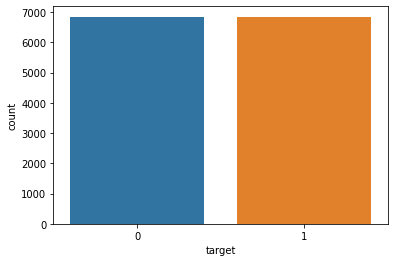

In [38]:

#Oversampling the data
smote = SMOTE(random_state = 101)
#Creating a new Oversampling Data Frame
df_oversampler = pd.DataFrame(X)
df_oversampler['target']
sns.countplot(df_oversampler['target'])

In [39]:
df_oversampler

,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,distance,severity,polar sentiment,neutral sentiment,target
0,20200630,1100,40.607243,-73.987260,0,0,0,0,0,0,0,0,4324995,685,9,0.025675,0.96275,1
1,20200630,1540,40.782787,-73.957410,0,0,0,0,0,0,0,0,4324800,440,7,0.000000,1.00000,1
2,20200628,1430,40.707860,-73.848460,1,0,0,0,0,0,1,0,4323925,800,4,0.159100,0.90650,1
3,20200627,1920,40.628730,-73.943340,0,0,0,0,0,0,0,0,4326375,1644,2,0.051350,0.94350,1
4,20200625,1400,40.757725,-73.779274,0,0,0,0,0,0,0,0,4323080,1156,1,0.476700,0.63100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13683,20200622,1161.69,40.348291,-73.895294,0,0,0,0,0,0,0,0,4329197,20,8,0.000000,0.00000,0
13684,20200624,1348.35,40.348291,-73.871571,0,0,0,0,0,0,0,0,4329392,36,4,0.000000,0.00000,0
13685,20200621,1586.62,40.348291,-73.769814,0,0,0,0,0,0,0,0,4317140,940,15,0.000000,0.00000,0
13686,20200617,845.949,40.630901,-73.777569,0,0,0,0,0,0,0,0,4321006,4416,13,0.000000,0.00000,0


In [40]:
df_oversampler.to_csv('preprocessed_6a.csv', mode='a')